# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


In [1]:
from IPython.display import Image
image_url = 'https://cdn.pixabay.com/photo/2015/04/29/19/33/cookbook-746005_1280.jpg'
Image(url=image_url)

# Introduction
Tasty Bytes is an online recipe search engine that displays a variety of recipes to visitors. Subscribers are provided with a full meal plan to ensure that customers are recommended balanced diets and tasty meals. To attract more potential subscribers, the product team of Tasty Bytes provides us with some recipe data records for a thorough analysis. With this dataset, they hope we can help them correctly predict which recipes attract the high traffic to the site and give strategic recommendations to optimise the business.

Our analysis is divided into four parts:
- Part I: Data Cleaning and Validation
- Part II: Metrics and Exploratory Data Analysis (EDA)
- Part III: Machine Learning Model Development
- Part IV: Model Evaluation and Decision

Let's begin!


# General Recommendations and Summary
Our analysis on the data provided by the product teams suggests the following actionable recommendations:

1. Monitor two business metrics. First, high-traffic rate, defined as: # of high-traffic recipes / # of total recipes. It helps to see how well our entire business, the recipe publications, is performing. Currently, the rate is 61%. Second, the category success rate, defined as: # of high-traffic recipes in a category / # of total recipes in that category. It helps us track the performance of each category.

2. Keep the contents and display more frequently vegtable, potatoes and pork categories, for their high category success rate. Adjust those of the breakfast and chicken categories by, for example, adding some vegetable salad dishes and low calories ingredients, as our analysis suggests that customers prefer breakfast and chicken dishes to be low calories. 

3. Decrease the total number of beverages category recipes given its poor popularity. Replace the sweet drinks (sugar contains more than 10 per serving) we currently have with low sugar ones. For example, vegetable or low-sugar fruit juice, herb tea, or coffee. 

Apart from the recommendations, we investigated in three kinds of machine learning classification models, and finally decide to adopt a Logistic Regression model to predict which recipes will lead to high-traffic. We succeeded in tuning a model that yields a 81% accuracy score and 84% precision (% of high-traffic recipes that is correctly identified). 

This model also tells us that the determining feature of a high or non-high recipe is the catogory of the recipe, not the nutritions or the servings. Specifically, recipes labelled as vegetables, potatoes and porks are very likely to become a high recipe, while those of beverages, breakfast and chicken are unlikely.

# **Part I: Data Cleaning and Validation**
Data cleaning and validation are fundemental for any kind of analysis. In this first part, we will do the following tasks: import necessary libraries for our projects, inspect the dataset, check duplicates and missing values, and correct the data types. 

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

In [3]:
#Import the data
df = pd.read_csv('recipe_site_traffic_2212.csv')

df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


The product manager told us that our data is constructed in the following formats:

`recipe`: Numeric. It is an unique identifier of the recipe.

`calories`, `carbohydrate`, `sugar`, `protein`: All numeric. The nutritional info of the recipes. 

`category`: Character. The groupings of the recipe, with a total of **10 types**.

`servings`: Numeric. The number of serivings of each recipe.

`high_traffic`: Character. Marked "High" if the recipe is of high traffic to the site.


In [4]:
#Check the shape and the information of our data
display(f'Shape of data: {df.shape}', df.info())

#Check if there are duplicates
print(f'Number of duplicated: {df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


'Shape of data: (947, 8)'

None

Number of duplicated: 0


In [5]:
#Check missing values
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

After a glimpse through the data, we found several **problems that need to be fixed**:

- `calories`, `carbohydrate`, `sugar`, `protein` all have 52 missing values. 

- `servings` here it is an object with some containing strings such as "4 as snack", yet it should be numeric!

- `category` should be categorical with 10 types, but here we found 11.

- `high_traffic` should be categorical. It has 373 missing values. Those without a 'High' stamp all return null. We educatedly guess that the null values should be 'non-high traffic'.

We do the followings to clean and fix the data. **Cells below are the codes of these operations.**

1. The eleventh meal category is "Chicken Breast", which is redundant and not a formal genre. We should categorise them into "Chicken" by string replacement. Then, we cast the type to categorical.

2. To fix the `high_traffic` column, we use 1 to signify "High trafic" and fill the missing values with 0 to signify "Non-high traffic".

3. We remove the redundant strings of `servings` column and change them into numeric.

4. Before fixing missing values of the four nutrition info columns, we look at their descriptive statistics and **plot the KDE plot (The distribution of 4 SINGLE VARIABLE respectively)** to gain some pictures about their distributions. We see all of them, particularly `calories` column, are right-skewed, a tendency that pulls the average up. 

5. With that said, it would be more reasonalbe to impute the missing values with median.

See now there is no missing values in the dataframe, and all the columns are with the right types. Data cleaning and validation mission accomplished!

In [6]:
#Fix the 'category' column
df.loc[df['category'] == 'Chicken Breast', 'category'] = 'Chicken'
df['category'] = df['category'].astype('category')

#Change 'high_traffic' column dtype
df['high_traffic'].replace('High', 1, inplace=True)
df['high_traffic'].fillna(0, inplace=True)
df['high_traffic'] = df['high_traffic'].astype('category')

#Fix and change 'servings' column dtype
df['servings'] = df['servings'].str[0].astype('int')

In [7]:
#Double check
display(df['servings'].unique())
display(df['category'].unique())

array([6, 4, 1, 2])

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert']
Categories (10, object): ['Beverages', 'Breakfast', 'Chicken', 'Dessert', ..., 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']

In [8]:
#Descripive statistics of the numeric columns
df[['calories', 'carbohydrate', 'sugar', 'protein']].describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


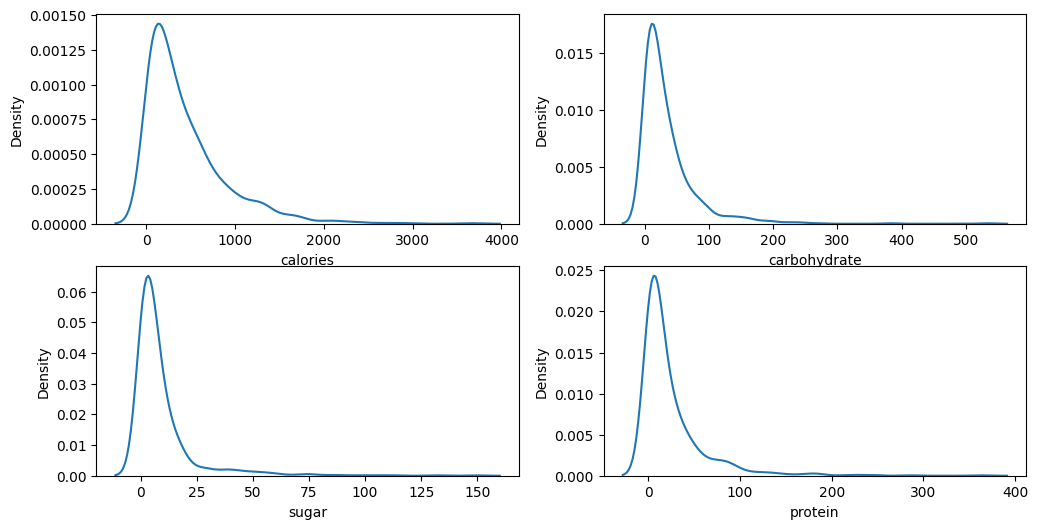

In [9]:
#Plot the distribution (Single variable plot)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 6))
df_nutr = df[['calories', 'carbohydrate', 'sugar', 'protein']]

for ax, col in zip(ax.flatten(), df_nutr.columns):
    sns.kdeplot(df_nutr[col], ax=ax)

plt.show()

In [10]:
#Impute missing values in nutrition columns with the median
nutritions = ['calories', 'carbohydrate', 'sugar', 'protein']
for nutr in nutritions:
    df[nutr].fillna(df[nutr].median(), inplace=True)
    
#Double check
df.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

# Part II: Exploratory Data Analysis (EDA)
After cleaning our data, we start doing some EDA to gain some insights. In this part, we will plot the data or do some statistical tests to answer different questions that help us make strategic plans for the business.

To gain a first insight, we plot a heatmap that shows the correlation coefficients of all the variables. Below is the plot we produce. The plot does not unveil any critical information. Variables are all of pretty low (nearly no) correlations. Calories and protein seem to have a positive relation, but very weak (0.18).

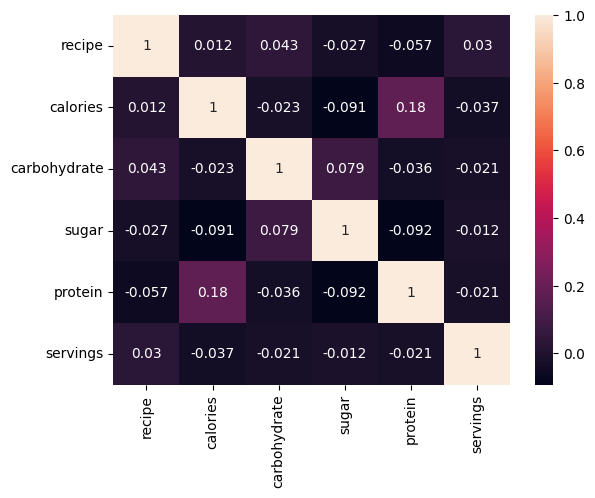

In [11]:
#Heatmap that shows the correlation coefficients of variables
sns.heatmap(df.corr(), annot=True)
plt.show()

Using the dataset, we **come up with several questions** and try to answer them using plots, data manipulation, and statistical analysis. Let's begin one by one:

### 1. Metric: What is the percentage of the high traffic recipes among the total?
Ans: 61%.

Obtained by dividing the number of high-marked recipe by total amount assuming the total 947 repicpes are what we published within a given time or all we have published. 61% is not low but still got space for improvement. This metric shows how well our recipes are performing overall and the frequency of our published contents attract browsers' eyes.

In [12]:
#Metrics: The Percentage of high traffic recipe
high_traffic_ratio = round(len(df[df['high_traffic'] == 1]) / len(df), 2) * 100
print(f'The percentage of high traffic recipe is {high_traffic_ratio} %')

The percentage of high traffic recipe is 61.0 %


### 2. Which category has the most high traffic recipes by count?
Ans: Potato, vegetable, and pork.

See graph 1, a bar chart that shows the counts of high traffic recipes by each category. We found that **Potato, Vegetable, and Pork** are the categories with the most high traffic recipes, whereas the Beverage genre got the least. 

In [13]:
#Graph 1: Bar plot. Which are the most popular food categories?
df_count = df.value_counts('category')
df_high_count = df[df['high_traffic'] == 1].value_counts('category')
cat_high = df_high_count.index
n_high = df_high_count.values

colors = ['lightgreen'] * 3 + ['lightslategray'] * 6 + ['red'] * 1

fig = go.Figure(go.Bar(x=cat_high, 
                       y=n_high,
                       marker_color=colors
                       ))

fig.update_layout(title_text='Counts of "High Traffic" Recipes by Category')
fig.show()

### 3. Which categories are the most and least successful?
Ans: Most - Vegetable, potato, and pork; Least - Chicken, breakfast, and beverage.

See graph 2, a bar chart that shows the % of high traffic recipes of each category. Graph 3 is an auxiliary chart that examines this relationship by listing the counts of high traffic recipes in a category and the total recipe in that category. By successful, we define as (_# of high trafic recipes and the total / Total # of recipes in a specific category_). We call it category success rate.

We are reassured that **Potato, Vegetable, and Pork have fantastic performance**. More than 90% recipes of these categories are marked with high traffic (vegetables 99%, almost all!). **The three worst categories are Chicken, Breakfast, and Beverage**. Especially chicken and breakfast. These two are the only ones that published more than 100 individual recipes, but less than half are of high-traffic. Not to mention in beverages only 5 out of 92 are popular. We will examine these genres and figure out what happened.

In [14]:
#Graph 2: Bar plot. Which category has the most high-traffic by proportion?
df_cat_ratio = (df_high_count / df_count).sort_values(ascending=False)
df_cat_ratio = pd.concat([df_cat_ratio, df_high_count, df_count], axis=1)
df_cat_ratio.columns = ['ratio', 'high_count', 'total']

fig = go.Figure(data=[go.Bar(
    x=df_cat_ratio.index,
    y=df_cat_ratio['ratio'],
    marker_color=colors,
)])
fig.update_layout(title_text='Category Success Rate: Percentage of high traffic each category')
fig.show()

In [15]:
#Graph 3: Bar plot. Compare the total counts and high traffic counts of each category.
fig = go.Figure([go.Bar(x=df_count.index, 
                        y=df_count.values,
                        name='Total Count'
                       ),
                 go.Bar(x=cat_high, 
                        y=n_high,
                        name='High Traffic Count'
                        )])

fig.update_layout(title_text='Total vs. High Traffic by Category')
fig.show()

### 4. How is the number of servings related to high-traffic or not?
Graph 4 is a bar plot that shows the ratios high-traffic recipes to total counts of each category. We found that recipes with 6 servings are slightly more possible to have high-traffic, but ratio does not differ strongly among different number of servings.

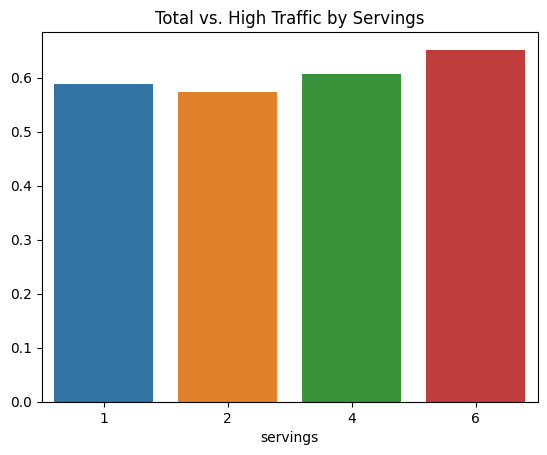

In [16]:
#Graph 4: Bar plot.  Which category has the most high-traffic by servings?
df['servings'].astype('category')
df_serv = df.groupby('servings')['high_traffic'].count()
df_serv_high = df.groupby('servings')['high_traffic'].apply(lambda x: (x==1).sum())
df_serv_porp = df_serv_high / df_serv

sns.barplot(x=df_serv_porp.index, y=df_serv_porp.values)
plt.title('Total vs. High Traffic by Servings')
plt.show()

### 5. What are the nutrition components of the most popular three (potato, veg, pork)?
Form the previous chart/table we see that almost all the potato, veg, and pork recipes are marked popular. Graph 5 shows the nutrition distributions of all the categories with the winner three coloured in red.

**Vegetables have one of the lowest calories distribution**, while that of potato and pork spread widely. Potato spreads wide in carbs, and pork in protein, which shouldn't be surprising. Apart from the indication of the popularity in low calories vegetable dishes, it is hard to say there is any critical nutritious evidence to make the 'trinity categories' surpass the other seven.

In [17]:
#Graph 5: Box plots. The nutritious components of most popular food cat
color_map = {cat:'red' if cat in ['Vegetable', 'Pork', 'Potato'] else 'lightslategrey' for cat in df['category'].unique()}

for nutr in nutritions:
    fig = px.box(df, x=nutr, y="category", color_discrete_map=color_map, color='category', title=nutr.capitalize())
    fig.show()

### 6. What happened to chicken and breakfast?
As mentioned previously, if we are spending a lot of time and effort on chicken recipes yet they only got little attention, we certainly have to diagnose this category and restrategise. We investigate this by plotting the box plots of nutritions spread between 'high-traffic recipe' and 'non-high traffic recipe' in the two categories.

We spotted some noticeable insights, see graph 6 & 7: For chicken genre, while carbs and proteins show little difference, **'winner' chickens have lower ranges in calories and sugar**! It implies that **customers lean more towards low calories and sugar cicken dishes**. The breakfast genre demonstrates more discrepencies. The 'winner breakfasts' have significantly lower range in calories, carbs and sugar, suggesting that **breakfast with low calories, carbs and sugar are more popular**. (maybe turn add more salad into breakfast, given the high popularity in veges!)

By the way, quite surprising that customers are acutally protein-indifferent, especially in chicken, given gyms and body-building are gaining more popularity nowadays.

In [18]:
#Graph 6: Box plot. Nutritious components difference between 'winner chicken' and 'ignored chicken'
df_chicken = df[df['category'] == 'Chicken']
for nutr in nutritions:
    fig = px.box(df_chicken, x=nutr, y='high_traffic', color='high_traffic', title=nutr.capitalize())
    fig.show()

In [19]:
#Graph 7: Box plot. Nutritious components difference between 'winner breakfast' and 'ignored breakfast'
df_breakfast = df[df['category'] == 'Breakfast']
for nutr in nutritions:
    fig = px.box(df_breakfast, x=nutr, y='high_traffic', color='high_traffic', title=nutr.capitalize())
    fig.show()

### 7. What is the relationship between the nutritions and high/low traffic?
We answer this question by comparing the mean values of the four nutritions between the 'high traffic' and 'non-high traffic' groups. See graph 8 the bar plots, we found:

- 'High traffic' group has higher average calories (451.7) than 'Non-high traffic' group (391.2).
- 'High traffic' group has higher average carbs (36.9) than 'Non-high traffic' group (30.4).
- 'High traffic' group has lower average sugars (7.9) than 'Non-high traffic' group (10.2).
- 'High traffic' group has higher average proteins (24.5) than 'Non-high traffic' group (21.8).

Are these differences significant? Or merely due to chance? We will use the individual t-test one the two groups to compare, with alpha = 0.05. Here's our hypotheses and the test result:

- H0: No difference in avg calories between 'High' and 'Non-high'; H1: Avg calories in 'High' is greater than 'Non-high'. **Result: p = 0.02, 'High traffic' group has a higher avg calories.**

- H0: No difference in avg carbs between 'High' and 'Non-high'; H1: Avg carbs in 'High' is greater than 'Non-high'. **Result: p = 0.01, 'High traffic' group has a higher avg carbs.**

- H0: No difference in avg sugar between 'High' and 'Non-high'; H1: Avg sugar in 'High' is _lower_ than 'Non-high'. **Result: p = 0.007 (highly statistically significant), 'High traffic' group has a lower avg sugar.**

- H0: No difference in avg proteins between 'High' and 'Non-high'; H1: Avg proteins in 'High' is greater than 'Non-high'. Result: p = 0.13, no significant difference in protein observed in both groups.

In the previous question, we found the carbs and calories in 'high-traffic' chicken and breakfast recipes are lower than the 'non-high' counterparts, which seems to be contradicting to this outcome. However, we can understand as the customers do have exclusive preferences and standards on carbs and calories in these two genres, which do not contribute to the higher average in the total high-traffic recipes. The higher average of calories and carbs in high-traffic recipes are the results after averaging with other remaining categories.


In [20]:
#Graph 8: Bar plots and tables. Compare average nutritions between high and non-high recipe.
for nutr in nutritions:
    nutr_group = df.groupby('high_traffic')[nutr].mean()
    display(nutr_group)
    fig = px.bar(nutr_group, x=nutr_group.index, y=nutr_group.values, title=f'{nutr}', color=nutr_group.index)
    fig.show()

high_traffic
0.0    391.177882
1.0    451.673920
Name: calories, dtype: float64

high_traffic
0.0    30.413458
1.0    36.864286
Name: carbohydrate, dtype: float64

high_traffic
0.0    10.193539
1.0     7.893850
Name: sugar, dtype: float64

high_traffic
0.0    21.777668
1.0    24.481098
Name: protein, dtype: float64

In [21]:
#Is the difference of protein significant between high traffic and non-high traffic?
high_group = df[df['high_traffic'] == 1]
nonhigh_group = df[df['high_traffic'] == 0]

for nutr in nutritions:
    if nutr == 'sugar':
        print(f'{nutr.capitalize()} group:')
        test_result = ttest_ind(high_group[nutr], nonhigh_group[nutr], alternative='less')
        print(f'T-statistics: {test_result[0]}, p-value: {test_result[1]}')
        if test_result[1] < 0.05:
            print(f'We reject the null hypothesis and support that the avg {nutr} of "high" group is lower')
        else:
            print(f'No significant evidence suggests that the avg {nutr} of "high" group is lower.')
        print('\n')
    else:
        print(f'{nutr.capitalize()} group:')
        test_result = ttest_ind(high_group[nutr], nonhigh_group[nutr], alternative='greater')
        print(f'T-statistics: {test_result[0]}, p-value: {test_result[1]}')
        if test_result[1] < 0.05:
            print(f'We reject the null hypothesis that the avg {nutr} of "high" group is higher.')
        else: 
            print(f'No significant evidence suggests that the avg {nutr} of "high" group is higher.')
        print('\n')

Calories group:
T-statistics: 2.0630371176466653, p-value: 0.019690907651625268
We reject the null hypothesis that the avg calories of "high" group is higher.


Carbohydrate group:
T-statistics: 2.269292000192546, p-value: 0.011737625559147471
We reject the null hypothesis that the avg carbohydrate of "high" group is higher.


Sugar group:
T-statistics: -2.4231356585362147, p-value: 0.007787083033032088
We reject the null hypothesis and support that the avg sugar of "high" group is lower


Protein group:
T-statistics: 1.1456623082157114, p-value: 0.12611247222420136
No significant evidence suggests that the avg protein of "high" group is higher.




### 8. How could we improve the terrible performance of beverages?
Based on our statistical analysis, high-traffic recipes are of lower average sugar compared with non-high traffic, and this result is highly statistically significant. Assuming, in general, the beverages are mostly sweet, we can reasonbly guess that sugar is the 'culprit' that drags the category popularity down. 

Below is the only 5 winner beverages information. With the box plot of graph 5 which indicates the median of sugar in beverages is around 8, we see that most of the drink's sugar is around or below that number (recipe 106, 902, and 386 slightly only above the edge). But how do we infer if sugar really matters or not?

The data of popular drinks is limited and hard to draw a conclusion only based on it. Given the similar property of drinks and dessert, we use the latter as a proxy to examine our customer's tastes. From graph 9, we found that the range, median and average sugar is less in the winner dessert. Yet in the proceeding statstical analysis, we did not find there is a significant difference in average sugar between high and non-high dessert recipe.  

Since we cannot determine if sugar really plays a role in drinks recipe's high traffic based on above reasonings, we believe a better recommendation will be to decrease the total number of the beverage recipe given its poor popularity. Yet it would be also great to replace some current sweet drinks with the low sugar alternatives (natural fruit or vegetable drinks) to keep running the experient, aimed to figure out sugar's role in drink recipe's performance.

In [22]:
#Here are the 5 'winner' drinks
bev_high = df[(df['category'] == 'Beverages') & (df['high_traffic'] == 1)]
bev_high

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
3,4,97.03,30.56,38.63,0.02,Beverages,4,1.0
105,106,396.37,16.85,2.48,0.27,Beverages,1,1.0
385,386,75.17,6.45,8.59,0.73,Beverages,2,1.0
652,653,0.54,30.59,10.45,0.36,Beverages,6,1.0
901,902,92.61,1.35,3.59,0.04,Beverages,6,1.0


In [23]:
#Graph 9: Box plot. Sugar distribution of dessert, as a proxy?
df_dessert = df[df['category'] == 'Dessert']
fig = px.box(df_dessert, x='sugar', y='high_traffic', color='high_traffic', title='Sugar in Dessert')
fig.show()

In [24]:
#Graph 10: Bar plot of avg sugar in dessert and hypothesis testing.
dessert_group = df_dessert.groupby('high_traffic')['sugar'].mean()
display(dessert_group)
fig = px.bar(dessert_group, x=dessert_group.index, y=dessert_group.values, title='Sugar in Dessert', color=dessert_group.index)
fig.show()

#Statistical Test 
high_group_des = df_dessert[(df_dessert['high_traffic'] == 1)]
nonhigh_group_des = df_dessert[df_dessert['high_traffic'] == 0]

test_result_des = ttest_ind(high_group_des['sugar'], nonhigh_group_des['sugar'], alternative='less')
print(f'T-statistics: {test_result_des[0]}, p-value: {test_result_des[1]}')
if test_result_des[1] < 0.05:
    print('We reject the null hypothesis and support that the avg sugar of "high" dessert group is lower')
else:
    print('No significant evidence suggests that the avg sugar of "high" dessert group is lower.')

high_traffic
0.0    38.117333
1.0    30.120189
Name: sugar, dtype: float64

T-statistics: -1.0810606851636602, p-value: 0.14143914703587512
No significant evidence suggests that the avg sugar of "high" dessert group is lower.


# Part III: Model Development
In this section we will develop a machine learning model to acheive our business goal: Predict which recipes will lead to high traffic correctly 80% of the time. 

Since we are predicting if a recipe will be a high-traffic one or not, **this is a classification question** and will require a classification model to solve. **Our baseline model is a logistic regression model**, and we select other two classification models for comparision: **K-Neighbour classifier, and random forest classifier**. 

The work flow goes as following: 

1. First, we perform feature engineering to transform the dataset so that it is ready to be fit in a machine learning algorithm.

2. Second, we split dataset into 70% train set and 30% test set for a 8-fold cross validation.

3. Hyperparameter tuning to find the best hyperparameters of the three models.

4. Fit and predict the data and evaluate their performances.

### Feature engineering

In this part:
1. We create a replicate dataset for machine learning called `df_ml`.

2. For fitting a machine learning model, our data must be all numeric with no missing data. So we cast the type of `high_traffic` column into integer (1: high-traffic, 0: non-high traffic). We use pd.get_dummies to create dummy variables for the `category` column. All the columns are with the correct types for a machine learning model now.

3. We set the target (Y) as the column `high_traffic`, what we want to predict, and the features (X) as the rest of the columns. 

4. The range and scale of the nutrition values (eg, calories and sugar) differ a lot, and the difference in numeric scale is prone to twist the data and affect the performance of machine learning models. Therefore, we use a Min-max scaler to adjust the values of calories, sugar, protein and carbs columns so that they are on the same scale. 

Till this step the feature engineering is done. Below are the codes that carry these tasks out:

In [25]:
#Feature engineering
df_ml = df.copy()
df_ml['high_traffic'] = df_ml['high_traffic'].astype('int')

In [26]:
#Turn categorical to dummies
df_ml = pd.get_dummies(df_ml)
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   recipe                  947 non-null    int64  
 1   calories                947 non-null    float64
 2   carbohydrate            947 non-null    float64
 3   sugar                   947 non-null    float64
 4   protein                 947 non-null    float64
 5   servings                947 non-null    int64  
 6   high_traffic            947 non-null    int64  
 7   category_Beverages      947 non-null    uint8  
 8   category_Breakfast      947 non-null    uint8  
 9   category_Chicken        947 non-null    uint8  
 10  category_Dessert        947 non-null    uint8  
 11  category_Lunch/Snacks   947 non-null    uint8  
 12  category_Meat           947 non-null    uint8  
 13  category_One Dish Meal  947 non-null    uint8  
 14  category_Pork           947 non-null    ui

In [27]:
#Set the features and targets
X = df_ml.drop(columns=['high_traffic'])
y = df_ml['high_traffic']

In [28]:
#Normalisation with minmax scaler
MMScaler = MinMaxScaler()
df_ml['calories'] = MMScaler.fit_transform(df_ml['calories'].values.reshape(-1, 1))
df_ml['carbohydrate'] = MMScaler.fit_transform(df_ml['carbohydrate'].values.reshape(-1, 1))
df_ml['sugar'] = MMScaler.fit_transform(df_ml['sugar'].values.reshape(-1, 1))
df_ml['protein'] = MMScaler.fit_transform(df_ml['protein'].values.reshape(-1, 1))

### Split the data for cross validation
we split dataset into 70% train set and 30% test set for a 8-fold cross validation.

In [29]:
#Split the data into train and test group
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)

#Create a KFold object later for validation
kf = KFold(n_splits=8, shuffle=True, random_state=1)

### Hyperparameter Tuning
Cosidering the number of each model's hyperparameter candidates and computing limits, we adopt both randomised search in logistic regression and random forest classifier, and grid search in knn model.

In [30]:
#Hyperparameter tuning: Logistics Regression
logreg = LogisticRegression()
params_dict_logreg = {'C': np.linspace(0.1, 1, 50),
                      'penalty': ['l1', 'l2'],
                      'tol': np.linspace(0.0001, 1.0, 50),}

logreg_hyptune = RandomizedSearchCV(logreg, params_dict_logreg, cv=kf, random_state=1)
logreg_cv = logreg_hyptune.fit(X_train, y_train)

display(logreg_cv.best_estimator_, logreg_cv.best_params_)
logreg_model = logreg_cv.best_estimator_

LogisticRegression(C=0.7244897959183674, tol=0.2449734693877551)

{'tol': 0.2449734693877551, 'penalty': 'l2', 'C': 0.7244897959183674}

In [31]:
#Hyperparameter tuning: K-Neighbour Classifier
knn = KNeighborsClassifier()
params_dict_knn = {'n_neighbors': np.arange(0, 11, 1)}

knn_hyptune = GridSearchCV(knn, param_grid=params_dict_knn, cv=kf)
knn_cv = knn_hyptune.fit(X_train, y_train)

display(knn_cv.best_estimator_, knn_cv.best_params_)
knn_model = knn_cv.best_estimator_

KNeighborsClassifier(n_neighbors=3)

{'n_neighbors': 3}

In [32]:
rf = RandomForestClassifier()
params_dict_rf = {'n_estimators': np.arange(100, 600, 100),
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'criterion': ['gini', 'entropy'],
                  'min_samples_leaf': np.arange(5, 50, 5)}

rf_hyptune = RandomizedSearchCV(rf, params_dict_rf, cv=kf, random_state=1)
rf_cv = rf_hyptune.fit(X_train, y_train)

display(rf_cv.best_estimator_, rf_cv.best_params_)
rf_model = rf_cv.best_estimator_

RandomForestClassifier(min_samples_leaf=15, n_estimators=400)

{'n_estimators': 400,
 'min_samples_leaf': 15,
 'max_features': 'sqrt',
 'criterion': 'gini'}

# Part IV: Model Evaluation
Now that we have the three models with their best hyperparameters, in this section we will compare the performances of the three models and choose the best one. The metrics we use include accuracy scores, classification report and precision score, roc curve, and roc auc score. 

### Accuracy score
In the box plot below, we see the 8-folded cross validation scores range of each model. On average, the logistic regression model has the best score, while knn performs the worst.

**Logistic regression model is also the only one that has an accuracy score more than 80%.**

In the cell below we also showed the accuracy scores of each model if we didn't do the hyperparameter tuning, just for additional information.

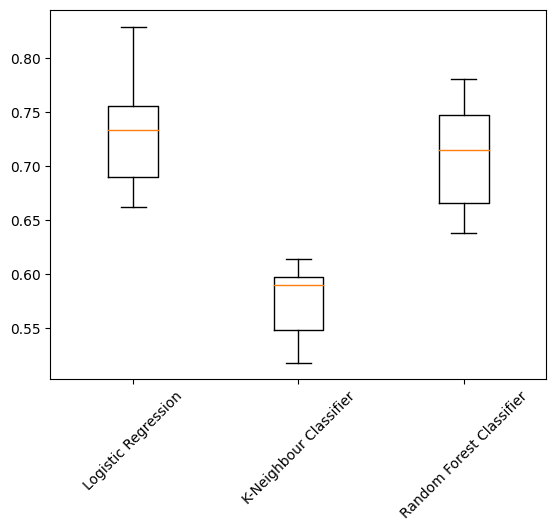

In [33]:
#Compare and choose the model
models = {'Logistic Regression': logreg_model,
          'K-Neighbour Classifier': knn_model,
          'Random Forest Classifier': rf_model,}
cvscores = []

for model in models.values():
    cv_score = cross_val_score(model, X_train, y_train, cv=kf)
    cvscores.append(cv_score)

plt.boxplot(cvscores, labels=models.keys())
plt.xticks(rotation=45)
plt.show()

In [34]:
#Prediction accuracy score
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name}:')
    print(f'The accuracy score: {accuracy_score(y_test, y_pred)}')
    print('\n')

Logistic Regression:
The accuracy score: 0.8070175438596491


K-Neighbour Classifier:
The accuracy score: 0.5508771929824562


Random Forest Classifier:
The accuracy score: 0.7684210526315789




In [35]:
#What if we don't do hyperparameter tuning?
model_nohype = {'Logistic Regression': LogisticRegression(),
                'KNN': KNeighborsClassifier(),
                'Random Forest Classifier': RandomForestClassifier()}

for name, model in model_nohype.items():
    model_nohype = model
    model_nohype.fit(X_train, y_train)
    y_pred_nohype = model_nohype.predict(X_test)
    print(f'Accuracy score of {name} if no hyperparameter tuning:', accuracy_score(y_test, y_pred_nohype))
    print('\n')

Accuracy score of Logistic Regression if no hyperparameter tuning: 0.8035087719298246


Accuracy score of KNN if no hyperparameter tuning: 0.5578947368421052


Accuracy score of Random Forest Classifier if no hyperparameter tuning: 0.7543859649122807




### Confusion matrix and classification report
Below is the plot of the confusion matrix and the classification report, assessing each classifier's performance in prediction the labels.

There are several metrics used to evaluate the performance of a classifier, such as precision, recall, and F-1 score. Which one should we use, in our case, to determine which model transcends in predicting the high-traffic recipes?

According to the product team, we choose a recipe to display on the website. We hope to choose a popular recipe so as to enhance the traffic of the rest of our website and attract subscriptions. We certainly don't want a recipe that is actually a non-high traffic but wrongly predicted as a high-traffic displayed on our page. It will be a waste of our website's space. Namely, we want to **avoid the false-positives as much as possible**, so we want a model that yields **the highest precision**.

**Logisitic regression model is the most ideal one**. We can see it has the highest precision metric (84%) among the three models.

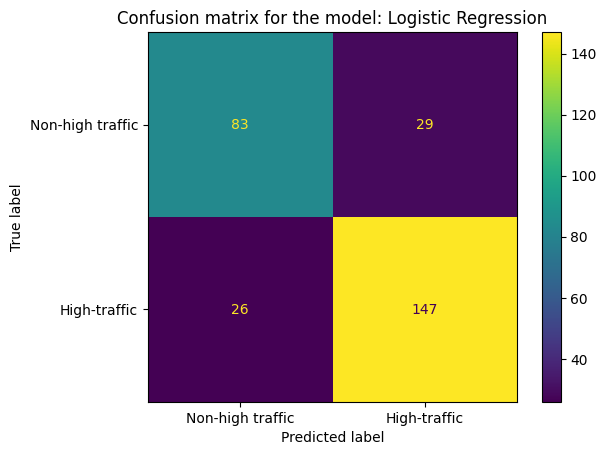

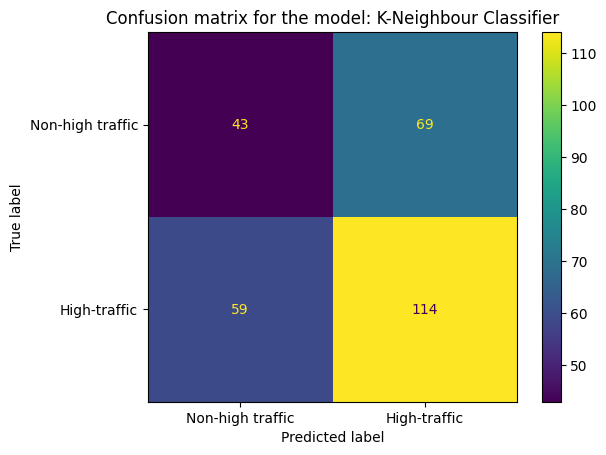

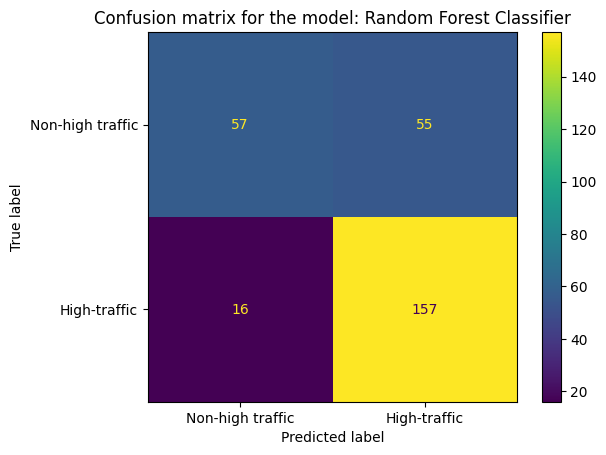

In [36]:
#Classification plot
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-high traffic', 'High-traffic'])
    disp.plot()
    plt.title(f'Confusion matrix for the model: {name}')
    plt.show()

In [37]:
#Classification Report
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    class_report = classification_report(y_test, y_pred)
    print(f'The classification report of {name} model:')
    print(class_report)
    print('\n')

The classification report of Logistic Regression model:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       112
           1       0.84      0.85      0.84       173

    accuracy                           0.81       285
   macro avg       0.80      0.80      0.80       285
weighted avg       0.81      0.81      0.81       285



The classification report of K-Neighbour Classifier model:
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       112
           1       0.62      0.66      0.64       173

    accuracy                           0.55       285
   macro avg       0.52      0.52      0.52       285
weighted avg       0.54      0.55      0.55       285



The classification report of Random Forest Classifier model:
              precision    recall  f1-score   support

           0       0.80      0.54      0.65       112
           1       0.76      0.91      0.83       173

  

### ROC curve and ROC AUC score
ROC is a plot that visualises the diagnostic ability of the binary classification models at all the classification level. The AUC stands of the area under the curve. The higher the value the AUC is, the better the ability is to distinguish between the positives and the negatives.

We found thatt KNN classifier has a poor performance in classifying, while logisitc regression and random forest classifier are similarly good, with the former outperforming slightly the latter.

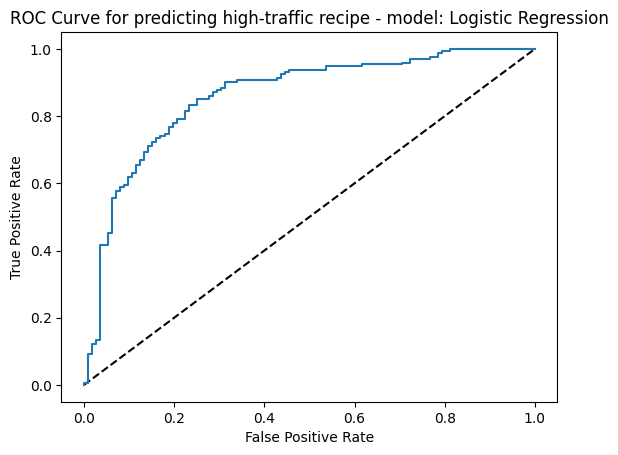

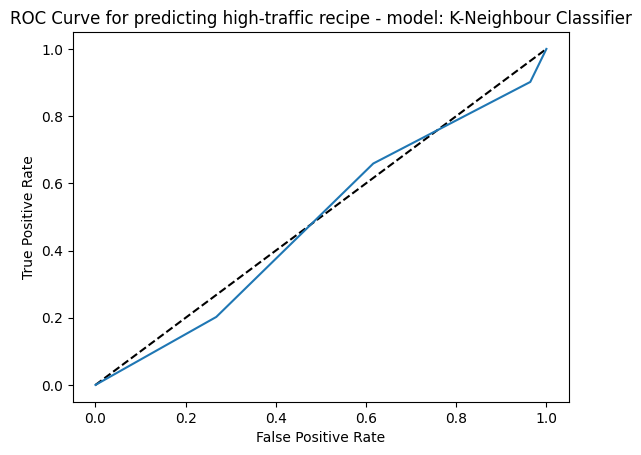

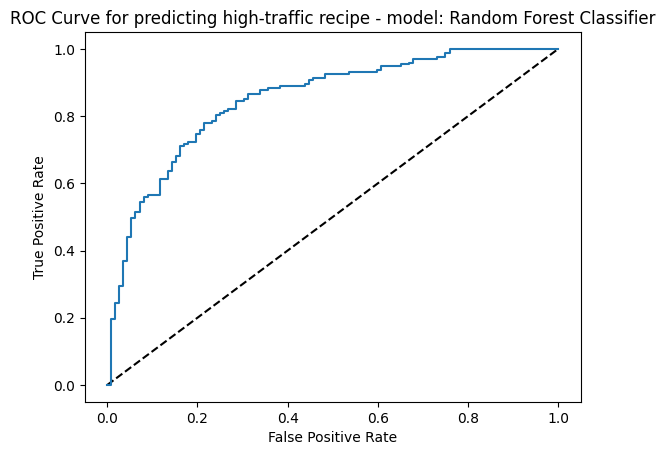

In [38]:
#The ROC and ROC AUC score
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for predicting high-traffic recipe - model: {name}')
    plt.show()

In [39]:
#ROC AUC Score
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
    print(f'The ROC AUC score of {name} model:')
    print(roc_auc_score(y_test, y_pred_proba))
    print('\n')

The ROC AUC score of Logistic Regression model:
0.8596717588769612


The ROC AUC score of K-Neighbour Classifier model:
0.48273637489677956


The ROC AUC score of Random Forest Classifier model:
0.8510012386457473




### Best model
All the several different metrics demonstrate that **the logistic regression model** surpasses the other two models. The logistic regression model is the most suitable to solve this business case. 

Last but not least, after having our model, we plot the coefficients to examine the feature importances. That is, to answer, which features are the most determining when predicting the outcome of the traffic of a recipe.

From the graph below, it is noticeable that **the category** is the determining factor of the popularity of a recipe. More specifically, being a vegetable, potato, and pork recipe makes it more possible for a recipe to be of high-traffic. Contrarily, being a bevereage puts a recipe at the lower hand, followed by breakfast or chicken. 

This will help the product team to design and strategise which kinds of recipe will be the best to grasp visitors' taste and to display more in the future.

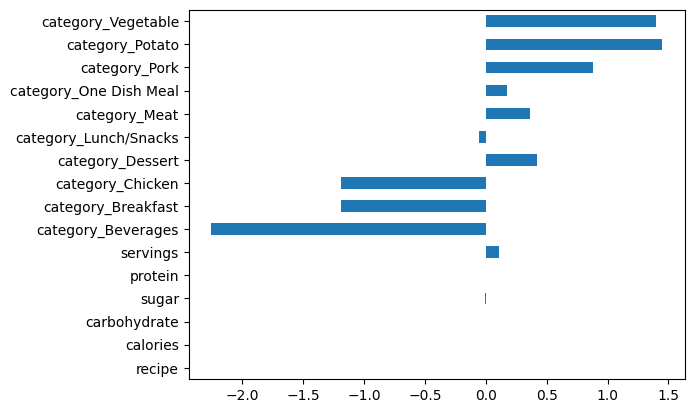

In [40]:
#Feature importance of Logistic Regression Model
logreg_fi = pd.Series(logreg_model.coef_[0], X.columns)
logreg_fi.plot(kind='barh')
plt.show()